### Описание проекта  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить закономерности определяющие успешность игры, что бы определить потенциально популярный продукт и спланировать рекламные кампании интернет-магазина.    
### Описание данных
- ***Name*** — название игры
- ***Platform*** — платформа
- ***Year_of_Release*** — год выпуска
- ***Genre*** — жанр игры
- ***NA_sales*** — продажи в Северной Америке (миллионы долларов)
- ***EU_sales*** — продажи в Европе (миллионы долларов)
- ***JP_sales*** — продажи в Японии (миллионы долларов)
- ***Other_sales*** — продажи в других странах (миллионы долларов)
- ***Critic_Score*** — оценка критиков (максимум 100)
- ***User_Score*** — оценка пользователей (максимум 10)
- ***Rating*** — рейтинг от организации ESRB  

### Изучение общей информации

In [1]:
import pandas as pd
import requests
import json
from tqdm import tqdm
import threading
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
from scipy import stats as st
import numpy as np

In [2]:
# Загрузим информацию о пользователях в переменную games_data
games_data = pd.read_csv('/datasets/games.csv')
# Посмотрим общую информацию
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
# Просмортим первые 10 записей
games_data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Вывод  
- Приведём названия столбцов к нижнему регистру
- Удалим строки с отсутствующими значениями в столбце *name*, т.к. идентифицировать игру невозможно
- Для заполнения пропусков воспользумся данными ресурса **igdb.com** - онлайн-каталог с информацией о видеоиграх с бесплатным API

### Предобработка данных

In [4]:
# Приведём названия столбцов к нижнему регистру
games_data.columns = games_data.columns.str.lower()
# Удалим строки с отсутствующими значениями в столбце name
games_data = games_data[games_data['name'].notna()]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Для заполнения пропусков воспользумся данными ресурса igdb.com. Для получения данных используем библиотеку requests, для увеличения скорости используем библиотеку threads. Для точного поиска по базе igdb составим словарь с названиями платформ и соостветствующими этим названиям идентификаторами в базе igdb. Затем добавим столбец *platform_id* с идентификаторами платформ с помощью метода map.

In [5]:
platforms = {'Wii': 5, 'NES': 18, 'GB': 33, 'DS': 20, 'X360': 12, 'PS3': 9, 'PS2': 8, 
             'SNES': 19, 'GBA': 24, 'PS4': 48, '3DS': 37, 'N64': 4, 'PS': 7, 'XB': 11, 
             'PC': 6, '2600': 59, 'PSP': 38, 'XOne': 49, 'WiiU': 41, 'GC': 21, 'GEN': 29, 
             'DC': 23, 'PSV': 46, 'SAT': 32, 'SCD': 78, 'WS': 57, 'NG': 42, 'TG16': 86, 
             '3DO': 50, 'GG': 35, 'PCFX': 128,}

games_data['platform_id'] = games_data['platform'].map(platforms)
games_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,5
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,18
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,5
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,5
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,33
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,33
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,20
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,5
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,5
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,18


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Заполним пропуски в переменной *year_of_release*:  
- с помощью библиотек requests и threading получим данные из базы данных igdb.com;
- запишем результаты в словарь *date_resp*;
- с помощью метода map() заполним пропуски в переменной *year_of_release*.

In [6]:
# Создадим объект блокировки для обеспечения правильной работы потоков со словарём
lock = threading.Lock()

In [7]:
# Создадим список для инициализации потоков
threads = []
# Создадим словарь
date_resp = {}

# Создадим функции для отправки запросов и обработки ответов
def get_date(name, platform):
    q = 'fields release_dates.*; where name = "{}" & release_dates.platform={};'.format(name, platform)
    response = requests.post(
       'https://api-v3.igdb.com/games',
        headers={
            'user-key': '4928649482c85258f27ea0b9a2b00c85',
            'Accept': 'application/json',
        },
        data = q.encode('UTF-8')
    )
    
    if (len(response.json()) > 0):
        
        for i in range(0, len(response.json()[0]['release_dates'])-1):
            if response.json()[0]['release_dates'][i]['human'] == 'TBD':
                continue
            elif response.json()[0]['release_dates'][i]['platform'] == platform:
                lock.acquire()
                date_resp[name] = response.json()[0]['release_dates'][i]['y']
                lock.release()
                continue
    date_bar.update(1)

# Создадим словарь с параметрами функции get_date и заполним его
get_date_params = {}

for index, row in games_data.loc[games_data['year_of_release'].isnull()].iterrows():
    get_date_params[row['name']] = row['platform_id']

date_bar = tqdm(total=len(get_date_params), desc='Queries', position=0)

# Инициализируем потоки
for key, value in get_date_params.items():
    threads.append(threading.Thread(target=get_date, args=(key, value,)))

# Запускаем потоки
for thread in threads:
    thread.start()

# Ждём остановки потоков
for thread in threads:
    thread.join()

Queries: 100%|█████████▉| 231/232 [00:08<00:00,  2.37it/s]

In [8]:
games_data.loc[games_data['year_of_release'].isnull(), 'year_of_release'] = games_data['name'].map(date_resp)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16564 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
platform_id        16713 non-null int64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.3+ MB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Заполним пропуски в переменной *rating*:  
- с помощью библиотек requests и threading получим данные из базы данных igdb.com;
- запишем результаты в словарь *rating_resp*;
- с помощью метода map() заполним пропуски в переменной *rating*.

In [9]:
# Создадим словарь с id рейтинга из базы igdb соответствующему значению рейтинга
esrb_ratings = {6: 'RP', 7: 'EC', 8: 'E', 9: 'E10', 10: 'T', 11: 'M', 12: 'AO'}

# Создадим список для инициализации потоков
threads = []
# Создадим словарь
rating_resp = {}

def get_rating(name, platform):
    q = 'fields age_ratings.*; where name = "{}" & age_ratings.category = 1 & platforms={};'.format(name, platform)
    response = requests.post(
        'https://api-v3.igdb.com/games',
        headers={
            'user-key': '4928649482c85258f27ea0b9a2b00c85',
            'Accept': 'application/json',
        },
        data = q.encode('UTF-8')
    )
    
    if len(response.json()) > 0:
    
        for i in range(0, len(response.json()[0]['age_ratings'])-1):
            if response.json()[0]['age_ratings'][i]['category'] == 1:
                #rating_id = response.json()[0]['age_ratings'][i]['rating']
                lock.acquire()
                rating_resp[name] = esrb_ratings[response.json()[0]['age_ratings'][i]['rating']]
                lock.release()
                continue
    rating_bar.update(1)

# Создадим словарь с параметрами функции get_date и заполним его
get_rating_params = {}

for index, row in games_data.loc[games_data['rating'].isnull()].iterrows():
    get_rating_params[row['name']] = row['platform_id']

rating_bar = tqdm(total=len(get_rating_params), desc='Queries', position=0)

# Инициализируем потоки
for key, value in get_rating_params.items():
    threads.append(threading.Thread(target=get_rating, args=(key, value,)))

# Запускаем потоки
for thread in threads:
    thread.start()

# Ждём остановки потоков
for thread in threads:
    thread.join()

Queries: 100%|██████████| 5852/5852 [03:24<00:00, 48.60s/it]    

In [10]:
games_data.loc[games_data['rating'].isnull(), 'rating'] = games_data['name'].map(rating_resp)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16564 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9992 non-null object
platform_id        16713 non-null int64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.3+ MB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Заполним пропуски в переменной *critic_score*:  
- с помощью библиотек requests и threading получим данные из базы данных igdb.com;
- запишем результаты в словарь *critic_resp*;
- с помощью метода map() заполним пропуски в переменной *critic_score*.

In [11]:
# Создадим список для инициализации потоков
threads = []
# Создадим словарь
critic_resp = {}

# Создадим функции для отправки запросов и обработки ответов
def get_critic(name, platform):
    q = 'fields aggregated_rating; where name = "{}" & platforms={};'.format(name, platform)
    response = requests.post(
       'https://api-v3.igdb.com/games',
        headers={
            'user-key': '4928649482c85258f27ea0b9a2b00c85',
            'Accept': 'application/json',
        },
        data = q.encode('UTF-8')
    )
    
    if (len(response.json()) > 0) and ('aggregated_rating' in response.json()[0]):
        lock.acquire()
        critic_resp[name] = round(response.json()[0]['aggregated_rating'], 0)
        lock.release()
        
    critic_bar.update(1)

# Создадим словарь с параметрами функции get_date и заполним его
get_critic_params = {}

for index, row in games_data.loc[games_data['critic_score'].isnull()].iterrows():
    get_critic_params[row['name']] = row['platform_id']

critic_bar = tqdm(total=len(get_critic_params), desc='Queries', position=0)

# Инициализируем потоки
for key, value in get_critic_params.items():
    threads.append(threading.Thread(target=get_critic, args=(key, value,)))

# Запускаем потоки
for thread in threads:
    thread.start()

# Ждём остановки потоков
for thread in threads:
    thread.join()

Queries: 100%|██████████| 7122/7122 [04:14<00:00, 118.12s/it]   

In [12]:
games_data.loc[games_data['critic_score'].isnull(), 'critic_score'] = games_data['name'].map(critic_resp)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16564 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8348 non-null float64
user_score         10014 non-null object
rating             9992 non-null object
platform_id        16713 non-null int64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.3+ MB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Заполним пропуски в переменной *user_score*:  
- с помощью библиотек requests и threading получим данные из базы данных igdb.com;
- запишем результаты в словарь *user_score_resp*;
- с помощью метода map() заполним пропуски в переменной *user_score*.

In [13]:
# Создадим список для инициализации потоков
threads = []
# Создадим словарь
user_score_resp = {}

# Создадим функции для отправки запросов и обработки ответов
def get_user_score(name, platform):
    q = 'fields rating; where name = "{}" & platforms={};'.format(name, platform)
    response = requests.post(
       'https://api-v3.igdb.com/games',
        headers={
            'user-key': '4928649482c85258f27ea0b9a2b00c85',
            'Accept': 'application/json',
        },
        data = q.encode('UTF-8')
    )
    
    if (len(response.json()) > 0) and ('rating' in response.json()[0]):
        lock.acquire()
        user_score_resp[name] = round((response.json()[0]['rating']/10), 1)
        lock.release()
        
    user_score_bar.update(1)

# Создадим словарь с параметрами функции get_date и заполним его
get_user_score_params = {}

for index, row in games_data.loc[games_data['user_score'].isnull()].iterrows():
    get_user_score_params[row['name']] = row['platform_id']

user_score_bar = tqdm(total=len(get_user_score_params), desc='Queries', position=0)

# Инициализируем потоки
for key, value in get_user_score_params.items():
    threads.append(threading.Thread(target=get_user_score, args=(key, value,)))

# Запускаем потоки
for thread in threads:
    thread.start()

# Ждём остановки потоков
for thread in threads:
    thread.join()

Queries: 100%|██████████| 5796/5796 [03:21<00:00, 82.61s/it]   

In [6]:
games_data.drop('platform_id', axis=1, inplace=True) # Удалим столбец platform_id за ненадобностью
games_data.loc[games_data['user_score'].isnull(), 'user_score'] = games_data['name'].map(user_score_resp)
games_data.info()

NameError: name 'user_score_resp' is not defined

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Значение *tbd* расшифровывается как *To Be Determined* и означает что колическтва оценок пользователей недостаточно для получения объективной средней оценки. Эти значения можно заменить на 0, что бы привести переменную *user_score* к типу float и в дальнейшем нулевые значения не учитывать.

In [7]:
games_data.loc[games_data['user_score'] == 'tbd', 'user_score'] = 0
games_data['user_score'] = games_data['user_score'].astype('float')
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Посчитаем суммарные продажи по всем регионам и запишем их в переменную *total_sales*.

In [8]:
games_data['total_sales'] = games_data['na_sales'] + games_data['eu_sales'] + games_data['jp_sales'] + games_data['other_sales']
games_data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


### Анализ данных

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Посмотрим количество выпущенных игр в разные года.

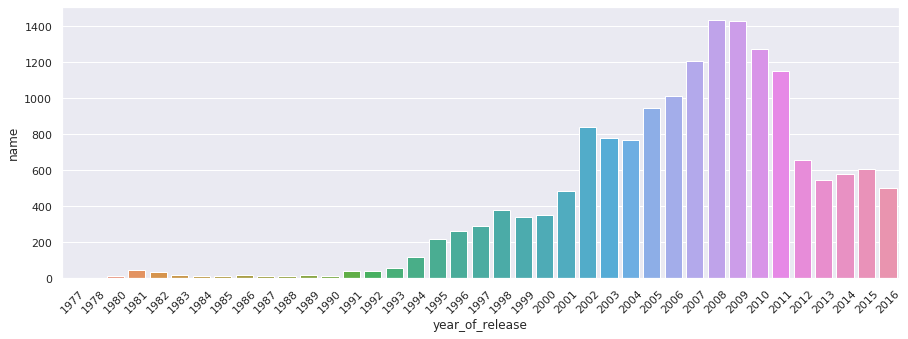

In [22]:
games_count_by_year = pd.pivot_table(games_data, index='year_of_release', values='name', aggfunc='count')
sns.set(rc={'figure.figsize':(15,5)})
plt.xticks(rotation=45)
bar = sns.barplot(y='name', x=games_count_by_year.index.astype('int'), data=games_count_by_year, ci=None)
plt.show(bar)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Посмотрим как менялись продажи по платформам:
- найдём топ 5 платформ по продажам за всё время;

In [23]:
top_5_platforms = pd.pivot_table(games_data, index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(5).reset_index()
top_5_platforms

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12


- построим распределение продаж игр на 5 самых популярных платформах по годам:

In [24]:
sales_by_platform = pd.pivot_table(games_data, index='year_of_release', values='total_sales',
                                   columns='platform', aggfunc='sum')
sales_by_platform = sales_by_platform.reset_index().melt(
    id_vars='year_of_release', value_vars=sales_by_platform.columns[1:])
sales_by_platform = sales_by_platform.loc[sales_by_platform['platform'].isin(top_5_platforms['platform'])]
# Обнаружился выброс у платформы DS, продаж на этой платформе в 85 году нет, т.к. дата релиза платформы 2004 год
sales_by_platform = sales_by_platform[sales_by_platform['year_of_release']>=2000]
sales_by_platform = sales_by_platform.loc[sales_by_platform['value'].notnull()]
sns.set(rc={'figure.figsize':(15,12)})
fig = px.line(sales_by_platform,
              x='year_of_release', y='value', color='platform', line_shape="spline", render_mode="svg")
for trace in fig.data:
    trace.name = trace.name.split('=')[1]
    trace.hovertemplate = '<b>' + trace.name + '</b><br>%{x} год<br>Продажи %{y} млн.$'
fig.update_layout(
    title={
        'text': "Продажи на топ-5 платформах",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Год',
    yaxis_title='Продажи, млн.$'
    )
fig.update_traces(mode='markers+lines')
fig.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Определим среднюю продолжительность "жизни" платформы. Для этого построим график по кол-ву лет в которых платформы имели продажи.

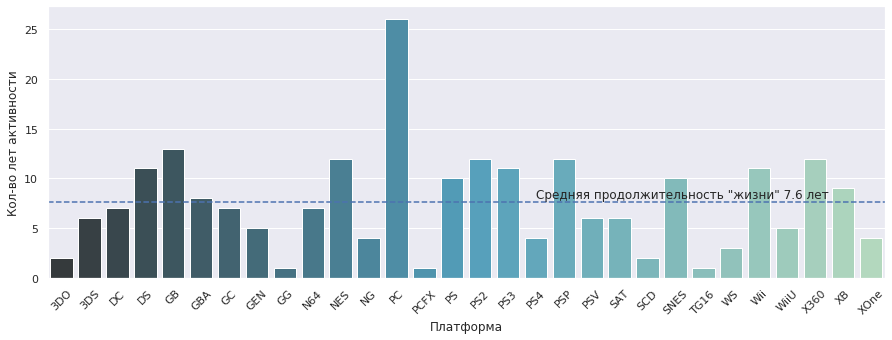

In [25]:
platform_life = pd.pivot_table(games_data, index='year_of_release', values='total_sales',
                                   columns='platform', aggfunc='sum')
platform_life = platform_life.reset_index().melt(id_vars='year_of_release', value_vars=platform_life.columns[1:])
platform_life = pd.pivot_table(platform_life, index='platform', values='value', aggfunc='count').reset_index()
platform_life_mean = platform_life['value'].mean()
sns.set(rc={'figure.figsize':(15,5)})
plt.xticks(rotation=45)
bar = sns.barplot(y='value', x='platform', data=platform_life, ci=None, palette='GnBu_d')
bar.axhline(platform_life_mean, ls='--')
bar.text(17, 8, 'Средняя продолжительность "жизни" {} лет'.format(platform_life_mean))
bar.set(xlabel='Платформа', ylabel='Кол-во лет активности')
plt.show(bar)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Общий объём проданных игр начал рост в 2002 году и продолжался до 2010 года, т.к. в этот период вышли самые популярные платформы (DS, PS2, PS3, Wii, X360). Рост пошёл на спад в 2010 году, как раз когда срок "жизни" этих платформ подошёл к концу и в 2012 году вернулся на уровень сопоставимый с 2001.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Для планирования продаж на следующий год нужно выбрать актуальные платформы за последние 4 года (т.к. средний срок "жизни" платформы 7,6 лет и выбрав актуальный период больше 4 лет мы захватим платформы которые "отживают своё"). Для этого построим график общих продаж по платформам за последние 4 года.

In [26]:
actual_sales = pd.pivot_table(games_data, index='year_of_release', values='total_sales',
                                   columns='platform', aggfunc='sum')
actual_sales = actual_sales.reset_index().melt(
    id_vars='year_of_release', value_vars=actual_sales.columns[1:])
actual_sales = actual_sales[(actual_sales['year_of_release']>2012) & (actual_sales['year_of_release'].notnull())]
actual_sales = actual_sales[actual_sales['value'].notnull()]
actual_sales['year_of_release'] = actual_sales['year_of_release'].astype('int')
sns.set(rc={'figure.figsize':(15,12)})
fig = px.line(actual_sales,
              x='year_of_release', y='value', color='platform', line_shape="spline", render_mode="svg")
for trace in fig.data:
    trace.name = trace.name.split('=')[1]
    trace.hovertemplate = '<b>' + trace.name + '</b><br>%{x} год<br>Продажи %{y} млн.$'
fig.update_layout(
    title={
        'text': "Продажи за последние 4 года",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Год',
    yaxis_title='Продажи, млн.$'
    )
fig.update_traces(mode='markers+lines')
fig.show()


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Актуальные платформы на 2016 год - *PS4, XBox One, Nintendo 3DS, PC, Nintendo WiiU*. На всех платформах продажи начали падение, вероятнее всего в ближайшие несколько лет будут выпущенные новые платформы.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Построим график по глобальным продажам каждой игры и разбивкой по платформам.

In [27]:
actual_platforms = ['PS4', 'XOne', '3DS', 'PC', 'WiiU']
game_sales_by_platform = games_data[(games_data['year_of_release']>2012) & (games_data['platform'].isin(actual_platforms))]
fig = px.box(game_sales_by_platform, x='platform', y='total_sales', points="all", color="platform", hover_data=["name"])
for i in range(len(fig.data)):
    fig.data[i].hovertemplate = '<b>%{customdata[0]}</b><br>%{x}<br>Продажи %{y} млн.$'
    fig.data[i].name = fig.data[i].name.split('=')[1]
fig.update_layout(
    title={
        'text': "Продажи по актуальным платформам",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Платформа',
    yaxis_title='Продажи, млн.$'
    )
fig.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Самаые популярные платформы - PlayStation 4 и Nintendo 3DS. XBox One проигрывает конкуренцию PlayStation 4 т.к. наиболее популярные мультиплатформенные тайтлы на PS4 продаются примерно в два раза лучше:
- Call of Duty: Black Ops 3 14,63 млн. долл. на PS4 и 7,39 млн. долл. на XBox One;
- Grand Theft Auto V 12,62 млн. долл. на PS4 и 5,47 млн. долл. на XBox One.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Медианные продажи на трёх стационарных игровых платформах (PS4, XBox One и WiiU) одинаковы - 0,2 млн. долл., на мобильной Nintendo 3DS - 0,09 млн. долл., на PC - 0,08 млн. долл.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Посмотрим, как влияют на продажи отзывы пользователей и критиков внутри платформ. Построим диаграммы рассеяния.

In [28]:
for platform in actual_platforms:
    scatter_data = games_data.loc[games_data['platform'] == platform]
    scatter_data['user_score'] = scatter_data['user_score'] * 10
    scatter_data = scatter_data.melt(id_vars='total_sales', value_vars=['user_score', 'critic_score'])
    fig = px.scatter(scatter_data, x='value', y='total_sales', color='variable', title=platform)
    fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Построим матрицу корреляции.

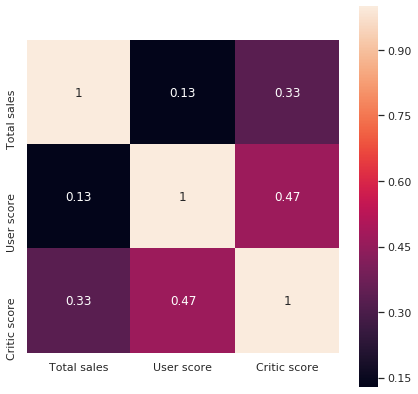

In [29]:
corr_data = game_sales_by_platform[['total_sales', 'user_score', 'critic_score']]
plt.figure(figsize=(7, 7))
labels = ['Total sales', 'User score', 'Critic score']
sns.heatmap(corr_data.corr(), annot=True, square=True, xticklabels=labels, yticklabels=labels)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Из графиков и матрицы корреляции следует что, скорее всего, оценки пользователей и критиков никак не влияют на продажи игры.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Построим график отображающий распределение прибыли от продажи игр по жанрам.

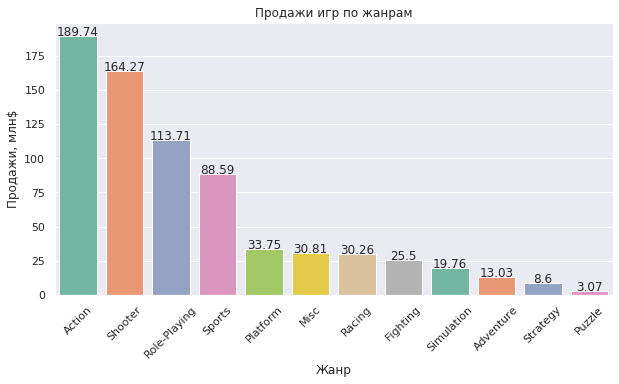

In [30]:
genre_sales_data = pd.pivot_table(game_sales_by_platform, index='genre', values='total_sales', aggfunc='sum'
                                 ).reset_index().sort_values(by='total_sales', ascending=False)
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(rotation=45)
bar = sns.barplot(y='total_sales', x='genre', data=genre_sales_data, ci=None, palette='Set2')
bar.set(xlabel='Жанр', ylabel='Продажи, млн$', title='Продажи игр по жанрам')
i=0
for p in bar.patches:
    height = p.get_height()
    bar.text(p.get_x()+p.get_width()/2., height + 0.1,
        round(genre_sales_data.iloc[i,1], 2),ha="center")
    i += 1
plt.show(bar)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Построим график отображающий кол-во выпущенных игр в каждом жанре.

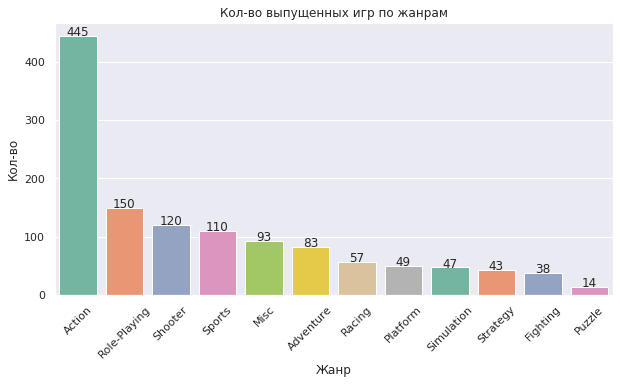

In [31]:
genre_sales_data = pd.pivot_table(game_sales_by_platform, index='genre', values='total_sales', aggfunc='count'
                                 ).reset_index().sort_values(by='total_sales', ascending=False)
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(rotation=45)
bar = sns.barplot(y='total_sales', x='genre', data=genre_sales_data, ci=None, palette='Set2')
bar.set(xlabel='Жанр', ylabel='Кол-во', title='Кол-во выпущенных игр по жанрам')
i=0
for p in bar.patches:
    height = p.get_height()
    bar.text(p.get_x()+p.get_width()/2., height + 0.1,
        genre_sales_data.iloc[i,1],ha="center")
    i += 1
plt.show(bar)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;По графику продаж можно выделить четыре самых прибыльных жанра игр (в порядке убывания):  
- Action
- Shooter
- RPG
- Sports  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Первым по популярности у разработчиков с большим отрывом лидирует жанр Acnion (443 игры, он же и самый прибыльный), но вторым по популярности является жанр RPG (150 игр), хотя выручка по играм этого жанра (114 млн. долл.) значительно уступает выручке по жанру Shooter (3-му по популярности у разработчиков, 120 игр, 164 млн. долл.).  
### Портрет пользователя по регионам  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Определим топ-5 платформ по продажам в каждом регионе

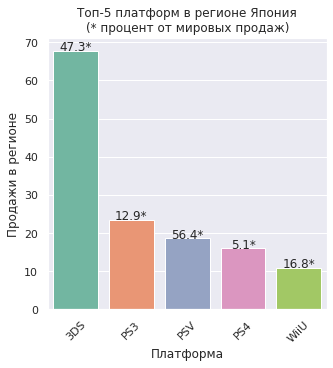

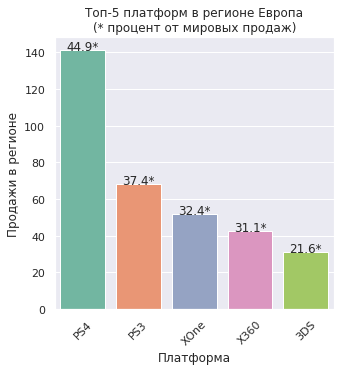

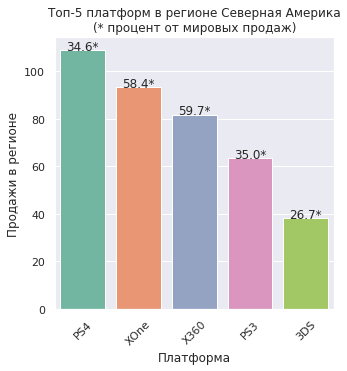

In [32]:
regions = {
           'jp_sales': 'Япония',
           'eu_sales': 'Европа',
           'na_sales': 'Северная Америка',
          }
for region_sales, region_name in regions.items():
    region_data = pd.pivot_table(games_data.loc[games_data['year_of_release']>2012], index='platform', values=
                                  [region_sales, 'total_sales'], aggfunc='sum').sort_values(by=region_sales, 
                                                                                            ascending=False).head(5).reset_index()
    sns.set(rc={'figure.figsize':(5,5)})
    plt.xticks(rotation=45)
    bar = sns.barplot(y=region_sales, x='platform', data=region_data, ci=None, palette='Set2')
    bar.set(xlabel='Платформа', ylabel='Продажи в регионе', title='Топ-5 платформ в регионе ' + region_name + 
            '\n(* процент от мировых продаж)')
    i=0
    for p in bar.patches:
        world_part = round(((region_data.iloc[i,1]/region_data.iloc[i,2]) * 100), 1).astype('str') + '*'
        height = p.get_height()
        bar.text(p.get_x()+p.get_width()/2., height + 0.1, world_part,ha="center")
        i += 1
    plt.show(bar)
    

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;По графикам видно что японцы играют на платформах отечественного производителя:
- Nintendo 3DS вне конкуренции, обгоняет ближайшего конкурента в 3 раза, объём продаж в регионе занимет 47% от общемирового;
- Следующие 3 места занимаю платформы PlayStation разных поколенй, интересно что PS3 обгоняет по продажам игр более свежую PS4;
- Последнее место занимает платформа от Nintendo - WiiU, которая не попала в топ по остальным регионам.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Европейцы предпочитают японские платформы от Sony - PS3 и PS4 (50% и 37% общемировых продаж соответственно).  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;В Североамериканском регионе PS4 тоже занимает первую строчку, но платформы местного производителя тоже не отстаюит, на XBox One и XBox 360 приходится 58% и 59% от общемировых продаж соответственно.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Определим топ-5 жанров по продажам в каждом регионе

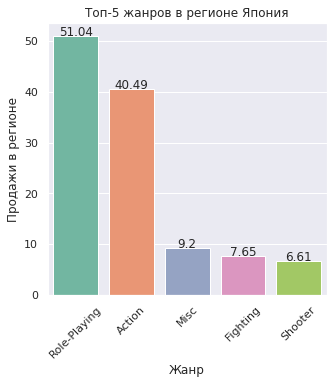

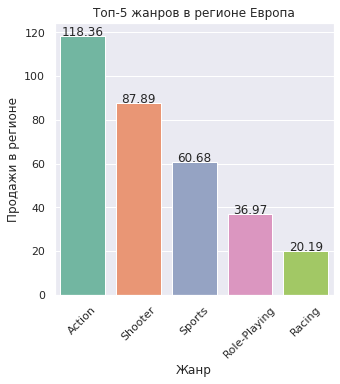

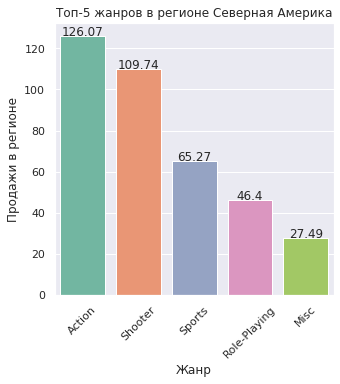

In [33]:
for region_sales, region_name in regions.items():
    region_data = pd.pivot_table(games_data.loc[games_data['year_of_release']>2012], index='genre', values=
                                 region_sales, aggfunc='sum').sort_values(by=region_sales, 
                                                                          ascending=False).head(5).reset_index()
    sns.set(rc={'figure.figsize':(5,5)})
    plt.xticks(rotation=45)
    bar = sns.barplot(y=region_sales, x='genre', data=region_data, ci=None, palette='Set2')
    bar.set(xlabel='Жанр', ylabel='Продажи в регионе', title='Топ-5 жанров в регионе ' + region_name)
    i=0
    for p in bar.patches:
        height = p.get_height()
        bar.text(p.get_x()+p.get_width()/2., height + 0.1, round(region_data.iloc[i, 1], 2), ha="center")
        i += 1
    plt.show(bar)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Пользователи Североамериканского региона и Европы похожи в своих предпочтениях: Action занимает 1-ое место, далее Shooter, спортивные симуляторы и RPG. В Японии традиционно жанр RPG занимает 1-ое место, затем Action, а Shooter занимает только 5-ую позицию.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Теперь определим влияет ли рейтинг ESRB на продажи в отдельном регионе.

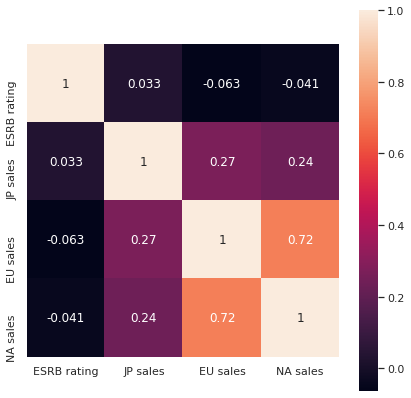

In [34]:
corr_data = games_data.loc[(games_data['year_of_release']>2012) & (games_data['rating'].notnull())]
corr_data = corr_data[['rating', 'jp_sales', 'eu_sales', 'na_sales']]
corr_data['rating'] = corr_data['rating'].astype('category').cat.codes
plt.figure(figsize=(7, 7))
labels = ['ESRB rating', 'JP sales', 'EU sales', 'NA sales']
sns.heatmap(corr_data.corr(), annot=True, square=True, xticklabels=labels, yticklabels=labels)
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Из матрици корреляции следует что ни в одном регионе рейтинг ESRB не влияет на продажи.  

### Проверка гипотез  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Гипотеза №1**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Эта гипотеза является основной, а альтернативная: средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [35]:
# Для проверки гипотез подготовим выборки по тарифам
xone_user_rating = games_data.loc[(games_data['platform'] == 'XOne') & games_data['user_score'].notnull()]
xone_user_rating = xone_user_rating[['user_score']]
pc_user_rating = games_data.loc[(games_data['platform'] == 'PC') & games_data['user_score'].notnull()]
pc_user_rating = pc_user_rating[['user_score']]

# Зададим уровень значимости
alpha = .05

# Расчитаем p-value и сделаем выводы
results = st.ttest_ind(
    xone_user_rating,
    pc_user_rating)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.00462487]
Отвергаем нулевую гипотезу


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Т.к. p-value меньше уровня значимости, то мы отвергаем основную гипотезу. Значит предполагаем что рейтинги пользователей XOne и PC различаются.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Гипотеза №2**: средние пользовательские рейтинги жанров Action и Sports разные. Эта гипотеза является альтернативной, а основная: средние пользовательские рейтинги жанров Action и Sports равны.

In [36]:
# Для проверки гипотез подготовим выборки по тарифам
action_user_rating = games_data.loc[(games_data['genre'] == 'Action') & games_data['user_score'].notnull()]
action_user_rating = action_user_rating[['user_score']]
sports_user_rating = games_data.loc[(games_data['genre'] == 'Sports') & games_data['user_score'].notnull()]
sports_user_rating = sports_user_rating[['user_score']]

# Зададим уровень значимости
alpha = .05

# Расчитаем p-value и сделаем выводы
results = st.ttest_ind(
    action_user_rating,
    sports_user_rating)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [4.68925792e-14]
Отвергаем нулевую гипотезу


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Т.к. p-value очень мало, то мы отвергаем основную гипотезу. Значит предполагаем что пользовательские рейтинги жанров action и sports различаются.

### Вывод  
- общий объём проданных игр начал рост в 2002 году и продолжался до 2010 года, т.к. в этот период вышли самые популярные платформы (DS, PS2, PS3, Wii, X360). Рост пошёл на спад в 2010 году, как раз когда срок "жизни" этих платформ подошёл к концу и в 2012 году вернулся на уровень сопоставимый с 2001;
- средний срок "жизни" платформы - 7,6 лет;
- для планирования продаж на следующий год нужно выбрать актуальные платформы за последние 4 года;
- актуальные платформы на 2016 год - *PS4, XBox One, Nintendo 3DS, PC, Nintendo WiiU*;
- самаые популярные платформы - PlayStation 4 и Nintendo 3DS. XBox One проигрывает конкуренцию PlayStation 4 т.к. наиболее популярные мультиплатформенные тайтлы на PS4 продаются примерно в два раза лучше;
- медианные продажи на трёх стационарных игровых платформах (PS4, XBox One и WiiU) одинаковы - 0,2 млн. долл., на мобильной Nintendo 3DS - 0,09 млн. долл., на PC - 0,08 млн. долл;
- скорее всего, оценки пользователей и критиков никак не влияют на продажи игры;
- первым по популярности у разработчиков с большим отрывом лидирует жанр Acnion (443 игры, он же и самый прибыльный), но вторым по популярности является жанр RPG (150 игр), хотя выручка по играм этого жанра (114 млн. долл.) значительно уступает выручке по жанру Shooter (3-му по популярности у разработчиков, 120 игр, 164 млн. долл.);
- японцы играют на платформах отечественного производителя (Nintendo и Sony);
- европейцы предпочитают японские платформы от Sony - PS3 и PS4 (50% и 37% общемировых продаж соответственно);
- в Североамериканском регионе PS4 тоже занимает первую строчку, но платформы местного производителя тоже не отстаюит, на XBox One и XBox 360 приходится 58% и 59% от общемировых продаж соответственно;
- у североамериканцев и европейцев схожие предпочтения по жанрам (в топе action, shooter, sports, RPG), вкусы японской аудитории разительно отличаются (RPG с большим отрывом, acttion, misc, fighting);
- ни в одном регионе рейтинг ESRB не влияет на продажи;
- скорее всего рейтинги пользователей XOne и PC различаются;
- скорее всего пользовательские рейтинги жанров action и sports различаются.